# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from libsvm.svmutil import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, classification_report

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Load Data

In [3]:
df = pd.read_csv('diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


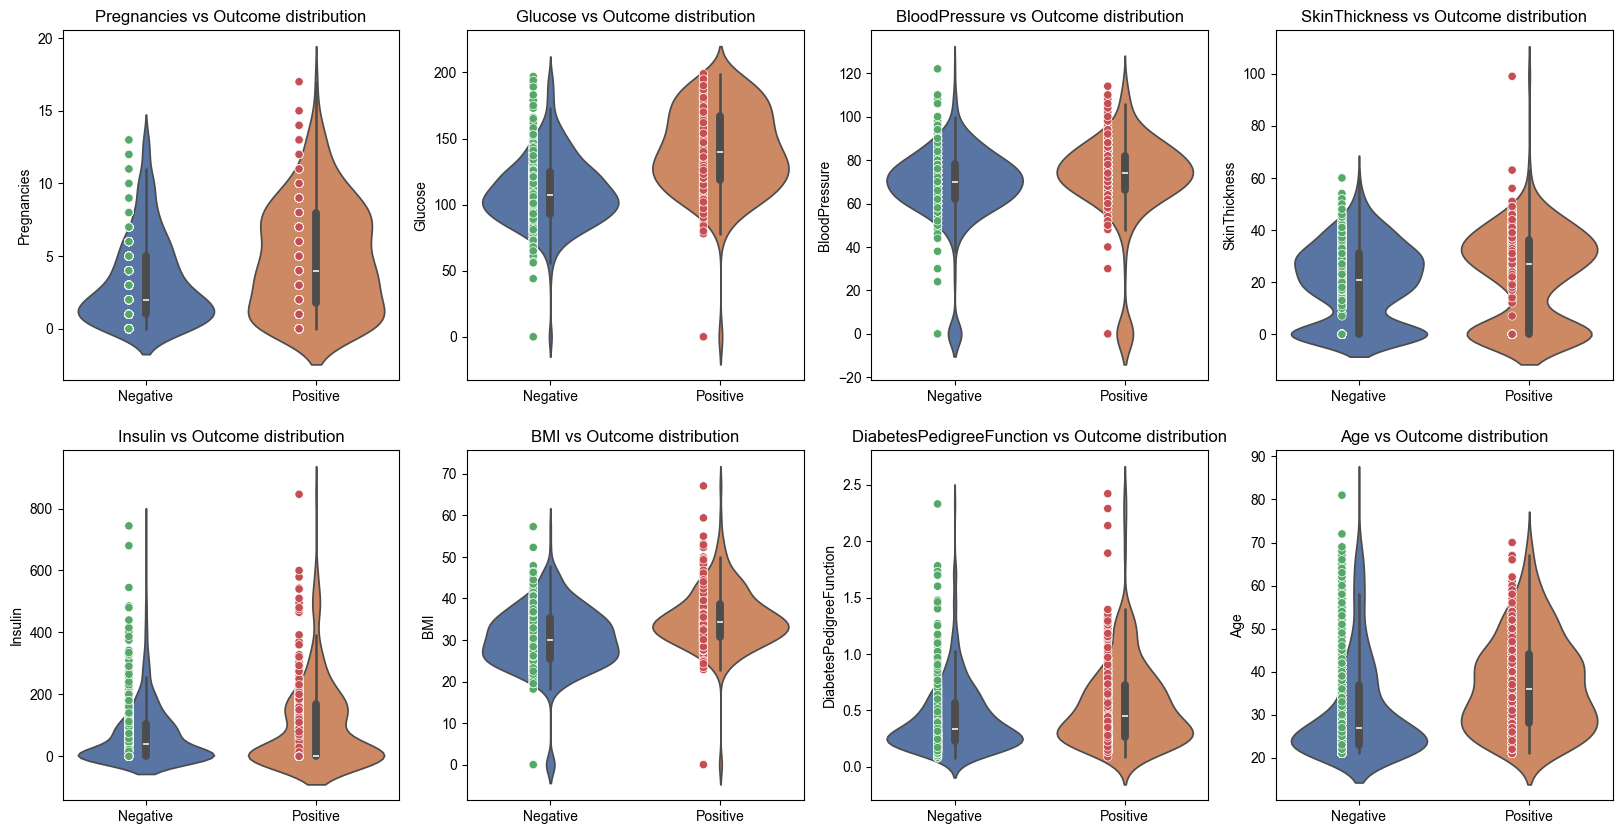

In [5]:
# Visualize the distribution of each feature through violin plots with the target values as hue, 
# and scatter plot to visualize the data points
df_visual = df.copy()
target_name = 'Outcome'

x_axis_scatter = df[target_name]
df_visual[target_name] = df_visual[target_name].map({0: 'Negative', 1: 'Postive'})

feature_names = df_visual.iloc[:, :-1].columns.tolist()
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
sns.set(font_scale = 1)
for i in range(len(feature_names)):
    plot = sns.violinplot(data=df, x=target_name,y=feature_names[i], ax=ax[i//4, i%4], hue=df_visual[target_name])
    sns.scatterplot(x=x_axis_scatter-0.1, y=df_visual[feature_names[i]], hue=df_visual[target_name], ax=ax[i//4, i%4], palette=['r', 'g'])
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xticks([0, 1])
    ax[i//4, i%4].set_xticklabels(['Negative', 'Positive'])
    ax[i//4, i%4].legend_.remove()
    ax[i//4, i%4].font_size = 14
    ax[i//4, i%4].set_title(f"{feature_names[i]} vs {target_name} distribution")
plt.show()

<Axes: xlabel='Outcome'>

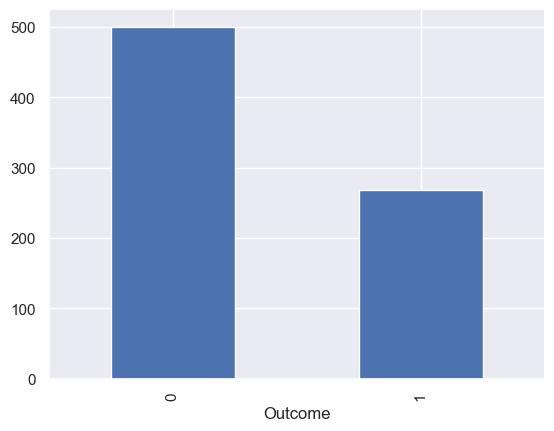

In [6]:
df['Outcome'].value_counts().plot(kind='bar')
# 1 means diabetes (positive), 0 means no diabetes (negative)

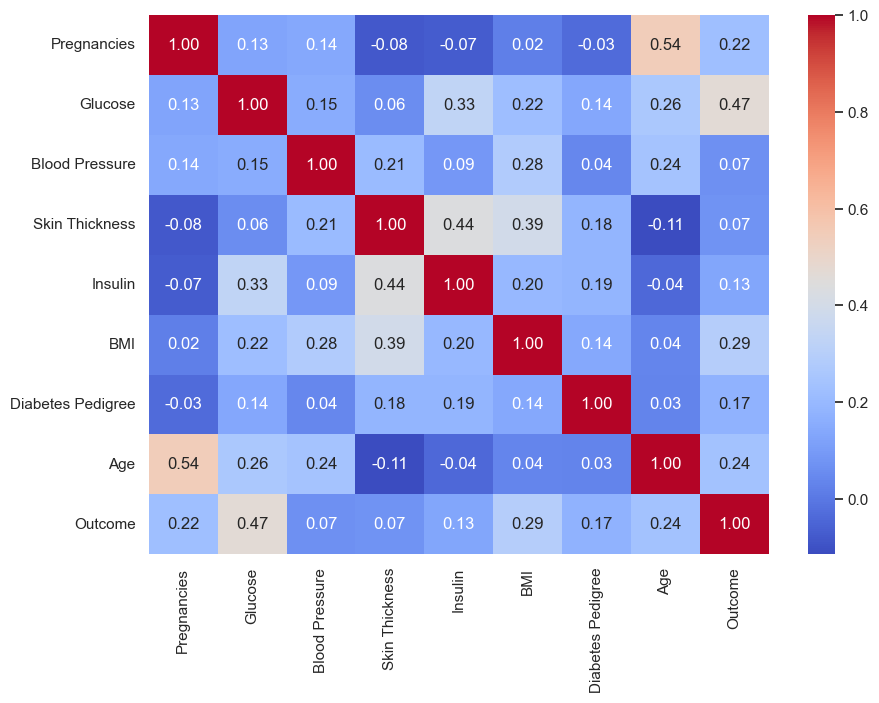

In [19]:
plt.figure(figsize=(10, 7))
df_corr = df.copy()
df_corr.columns = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree', 'Age', 'Outcome']
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [14]:
# Calculate the correlation between 'Outcome' and other columns
correlation_with_outcome_pearson = df.corr(method='pearson')['Outcome'].drop('Outcome')
correlation_with_outcome_kendall = df.corr(method='kendall')['Outcome'].drop('Outcome')
correlation_with_outcome_spearman = df.corr(method='spearman')['Outcome'].drop('Outcome')

# Create a DataFrame to visualize the correlation
correlation_df = pd.DataFrame({
    'Pearson Correlation with Outcome': correlation_with_outcome_pearson,
    'Kendall Correlation with Outcome': correlation_with_outcome_kendall, 
    'Spearman Correlation with Outcome': correlation_with_outcome_spearman})
correlation_df.reset_index(inplace=True)
correlation_df.rename(columns={'index': 'Feature'}, inplace=True)

# Display the correlation table
correlation_df.sort_values(by='Pearson Correlation with Outcome', ascending=False)

,Feature,Pearson Correlation with Outcome,Kendall Correlation with Outcome,Spearman Correlation with Outcome
1,Glucose,0.466581,0.390565,0.475776
5,BMI,0.292695,0.253676,0.309707
7,Age,0.238356,0.257363,0.309040
0,Pregnancies,0.221898,0.170370,0.198689
6,DiabetesPedigreeFunction,0.173844,0.143359,0.175353
4,Insulin,0.130548,0.058531,0.066472
3,SkinThickness,0.074752,0.076297,0.089728
2,BloodPressure,0.065068,0.119206,0.142921


# Preprocess

In [8]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].apply(lambda x: np.nan if x <= 30 else x)
df['SkinThickness'] = df['SkinThickness'].apply(lambda x: np.nan if x >= 80 else x)
df['BMI'] = df['BMI'].replace(0, np.nan)

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,730.000000,540.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.587671,29.024074,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.073443,10.045046,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,38.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=random_state, stratify=y_train_val)

from sklearn.preprocessing import StandardScaler

preprocess = Pipeline([
    ('imputer', IterativeImputer(random_state=random_state)),
    ('scaler',StandardScaler())
])

X_train = preprocess.fit_transform(X_train)
X_train_val = preprocess.transform(X_train_val)
X_val = preprocess.transform(X_val)
X_test = preprocess.transform(X_test)
y_train = np.array(y_train)
y_train_val = np.array(y_train_val)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Function

In [10]:
def show_epoch(history, metric, with_val=True, figsize=(10, 5), subplots=(1, 2)):
    # Plot accuracy, f1 score and loss over epochs
    fig, ax = plt.subplots(subplots[0], subplots[1] ,figsize=figsize)
    axs = ax.flatten()
    for i, m in enumerate(metric):
        axs[i].plot(history[m])
        if with_val:
            axs[i].plot(history[f'val_{m}'])
        axs[i].set_title(f'Model {m}')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(m)
        axs[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def show_result(X_actual, y_actual, model):
    y_pred = model.predict(X_actual)
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred_bin = np.argmax(y_pred, axis=1)
    else:
        y_pred_bin = np.round(y_pred)
    if len(y_actual.shape) > 1 and y_actual.shape[1] > 1:
        y_actual_bin = np.argmax(y_actual, axis=1)
    else:
        y_actual_bin = y_actual
        
    cm_val = confusion_matrix(y_actual_bin, y_pred_bin)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Negative', 'Positive'])
    fig, ax = plt.subplots()
    cm_disp.plot(ax=ax)
    ax.grid(False)  # Disable the grid
    plt.show()
    
    print(classification_report(y_actual_bin, y_pred_bin))
    
    f1 = f1_score(y_actual_bin, y_pred_bin, average='weighted')
    recall = recall_score(y_actual_bin, y_pred_bin, average='weighted')
    precision = precision_score(y_actual_bin, y_pred_bin, average='weighted')
    accuracy = accuracy_score(y_actual_bin, y_pred_bin)

    print(f'F1 Score: {f1*100:.2f}%')
    print(f'Recall: {recall*100:.2f}%')
    print(f'Precision: {precision*100:.2f}%')  
    print(f'Accuracy: {accuracy*100:.2f}%')  
    
    return f1, recall, precision, accuracy

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Model Single-Layer Perceptron

In [11]:
metric = ['loss', 'f1_score']

In [12]:
nn_slp = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])
nn_slp.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score])
history_slp = nn_slp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - f1_score: 0.5776 - loss: 0.6582 - val_f1_score: 0.5607 - val_loss: 0.6894
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.5797 - loss: 0.6494 - val_f1_score: 0.5660 - val_loss: 0.6777
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.5891 - loss: 0.6416 - val_f1_score: 0.5714 - val_loss: 0.6669
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5954 - loss: 0.6345 - val_f1_score: 0.5882 - val_loss: 0.6569
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5962 - loss: 0.6280 - val_f1_score: 0.5800 - val_loss: 0.6476
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.5997 - loss: 0.6220 - val_f1_score: 0.5859 - val_loss: 0.6391
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.6094 - loss: 0.6165 - val_f1_score: 0.5859 - val_loss: 0.6311
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.6042 - loss: 0.6114 - val_f1_score: 0.5918 - 

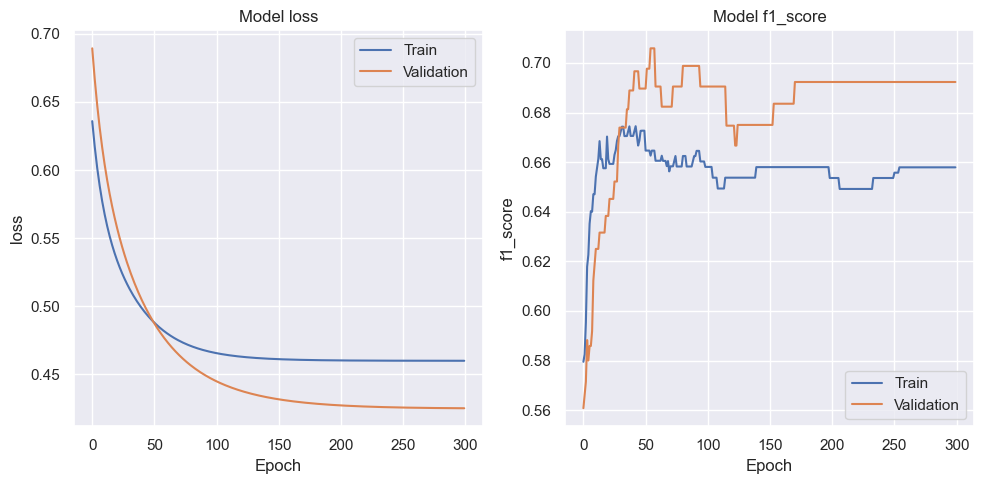

In [13]:
show_epoch(history_slp.history, metric)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


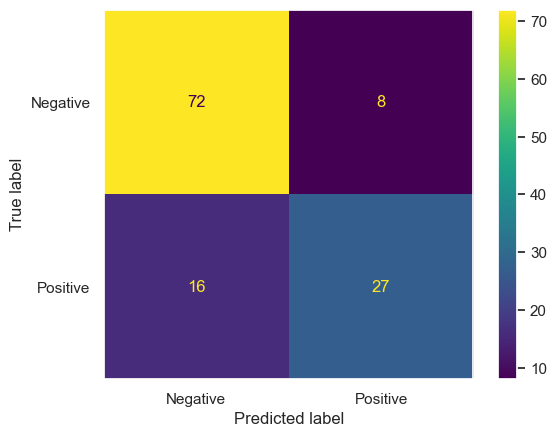

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        80
           1       0.77      0.63      0.69        43

    accuracy                           0.80       123
   macro avg       0.79      0.76      0.77       123
weighted avg       0.80      0.80      0.80       123

F1 Score: 79.95%
Recall: 80.49%
Precision: 80.18%
Accuracy: 80.49%


In [14]:
f1_slp, rec_slp, prec_slp, acc_slp = show_result(X_val, y_val, nn_slp)

## Implement Early Stopping

In [15]:
nn_slp_es = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])
nn_slp_es.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score])
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history_slp_es = nn_slp_es.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[earlyStopping], verbose=0)

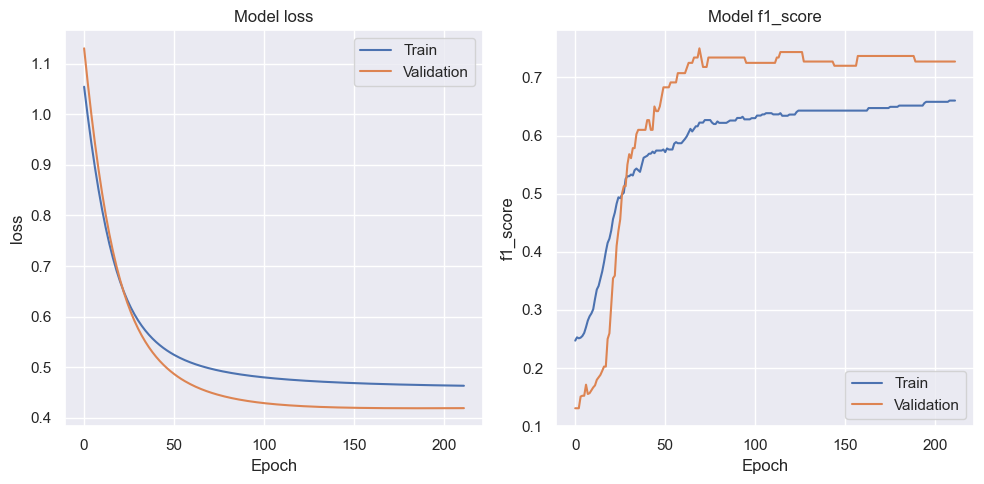

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


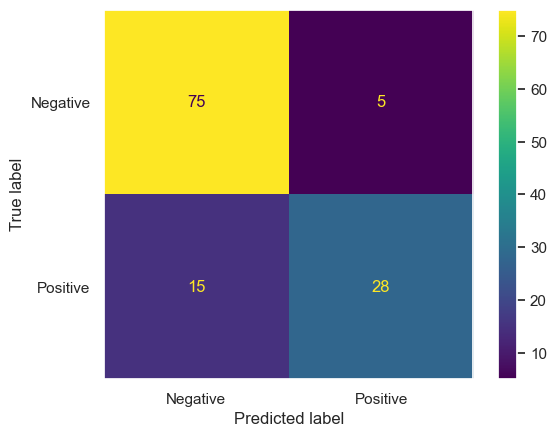

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        80
           1       0.85      0.65      0.74        43

    accuracy                           0.84       123
   macro avg       0.84      0.79      0.81       123
weighted avg       0.84      0.84      0.83       123

F1 Score: 83.15%
Recall: 83.74%
Precision: 83.86%
Accuracy: 83.74%


In [16]:
show_epoch(history_slp_es.history, metric)
f1_slp_es, rec_slp_es, prec_slp_es, acc_slp_es = show_result(X_val, y_val, nn_slp_es)

## Implement Class Weight

In [17]:
class_weight = {0: y_train.shape[0]/np.sum(y_train==0), 1: y_train.shape[0]/np.sum(y_train==1)}

In [18]:
nn_slp_es_cw = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])
nn_slp_es_cw.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score])
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history_slp_es_cw = nn_slp_es_cw.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, verbose=0, class_weight=class_weight, callbacks=[earlyStopping])

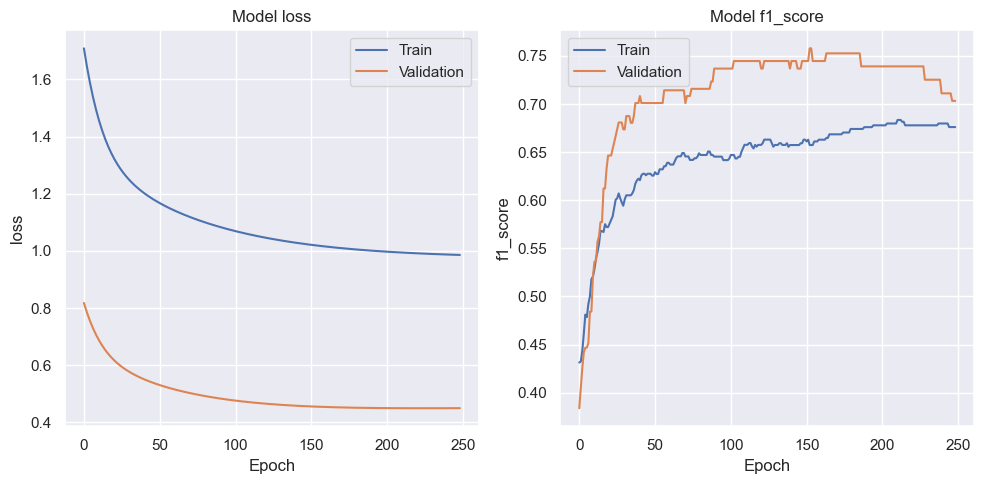

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000275927BEB60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


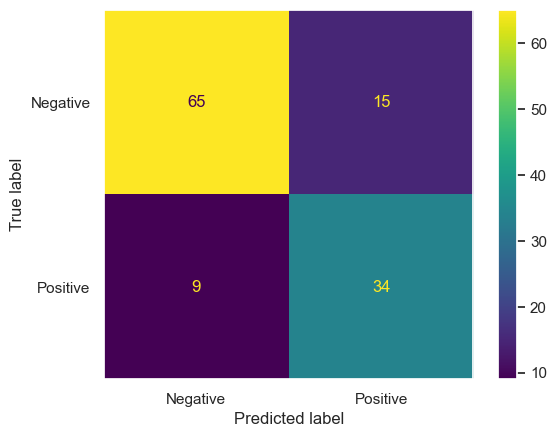

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        80
           1       0.69      0.79      0.74        43

    accuracy                           0.80       123
   macro avg       0.79      0.80      0.79       123
weighted avg       0.81      0.80      0.81       123

F1 Score: 80.74%
Recall: 80.49%
Precision: 81.39%
Accuracy: 80.49%


In [19]:
show_epoch(history_slp_es_cw.history, metric)
f1_slp_es_cw, rec_slp_es_cw, prec_slp_es_cw, acc_slp_es_cw = show_result(X_val, y_val, nn_slp_es_cw)

## Using Focal as a Loss

In [20]:
from tensorflow import keras
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

In [21]:
nn_slp_es_focal = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])
nn_slp_es_focal.compile(optimizer='adam', loss=focal_loss(), metrics=[F1Score])
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history_slp_es_focal = nn_slp_es_focal.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, verbose=0, callbacks=[earlyStopping])

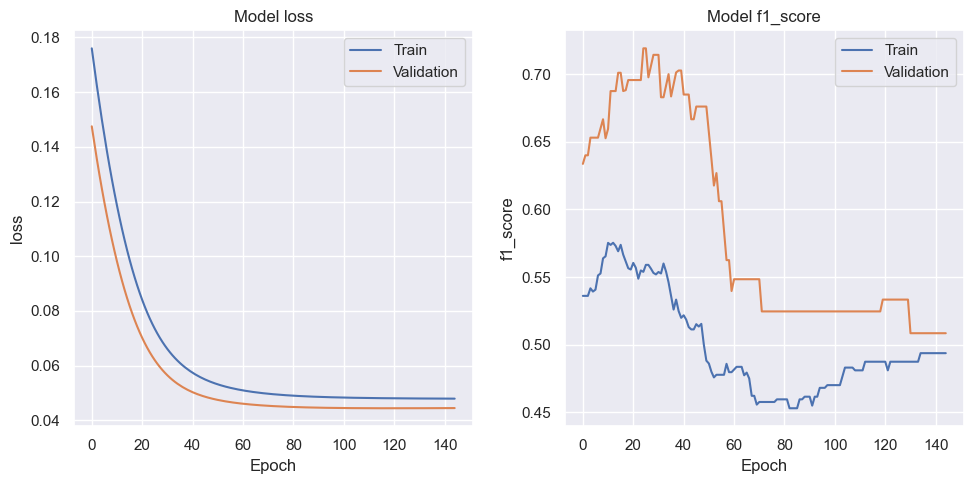

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


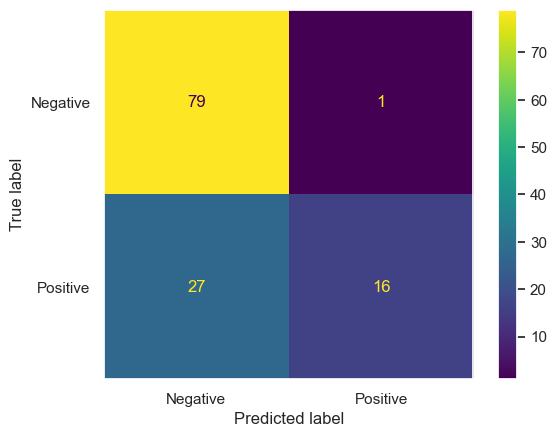

              precision    recall  f1-score   support

           0       0.75      0.99      0.85        80
           1       0.94      0.37      0.53        43

    accuracy                           0.77       123
   macro avg       0.84      0.68      0.69       123
weighted avg       0.81      0.77      0.74       123

F1 Score: 73.89%
Recall: 77.24%
Precision: 81.38%
Accuracy: 77.24%


In [22]:
show_epoch(history_slp_es_focal.history, metric)
f1_slp_es_focal, rec_slp_es_focal, prec_slp_es_focal, acc_slp_es_focal = show_result(X_val, y_val, nn_slp_es_focal)

## Handle Class Imbalance in Training set with SMOTE 

In [23]:
import sklearn
print(sklearn.__version__)

1.5.1


In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [29]:
nn_slp_es_smote = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])
nn_slp_es_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score])
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history_slp_es_smote = nn_slp_es_smote.fit(X_resampled, y_resampled, validation_data=(X_val, y_val), epochs=300, verbose=0, callbacks=[earlyStopping])

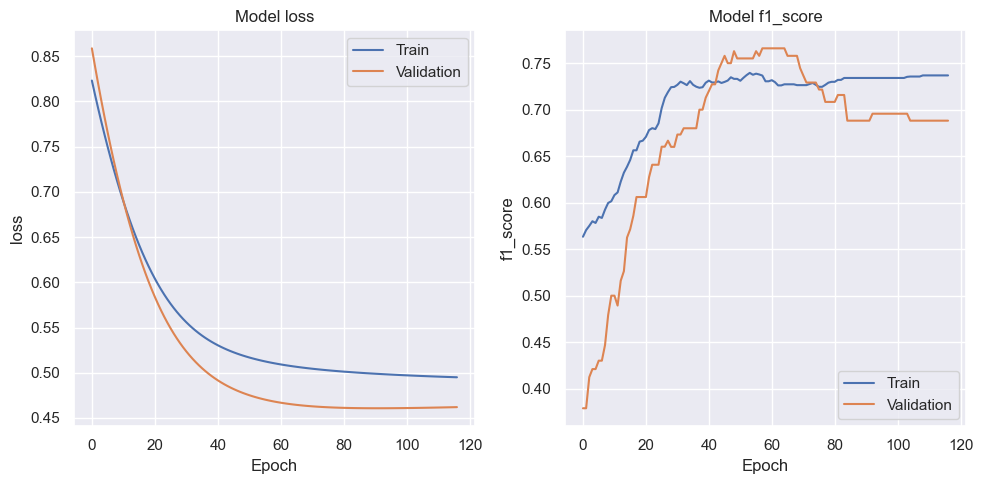

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


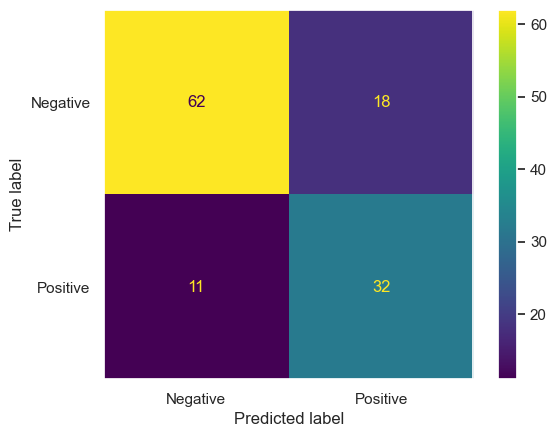

              precision    recall  f1-score   support

           0       0.85      0.78      0.81        80
           1       0.64      0.74      0.69        43

    accuracy                           0.76       123
   macro avg       0.74      0.76      0.75       123
weighted avg       0.78      0.76      0.77       123

F1 Score: 76.77%
Recall: 76.42%
Precision: 77.61%
Accuracy: 76.42%


In [30]:
show_epoch(history_slp_es_smote.history, metric)
f1_slp_es_smote, rec_slp_es_smote, prec_slp_es_smote, acc_slp_es_smote = show_result(X_val, y_val, nn_slp_es_smote)

# Model for Comparison

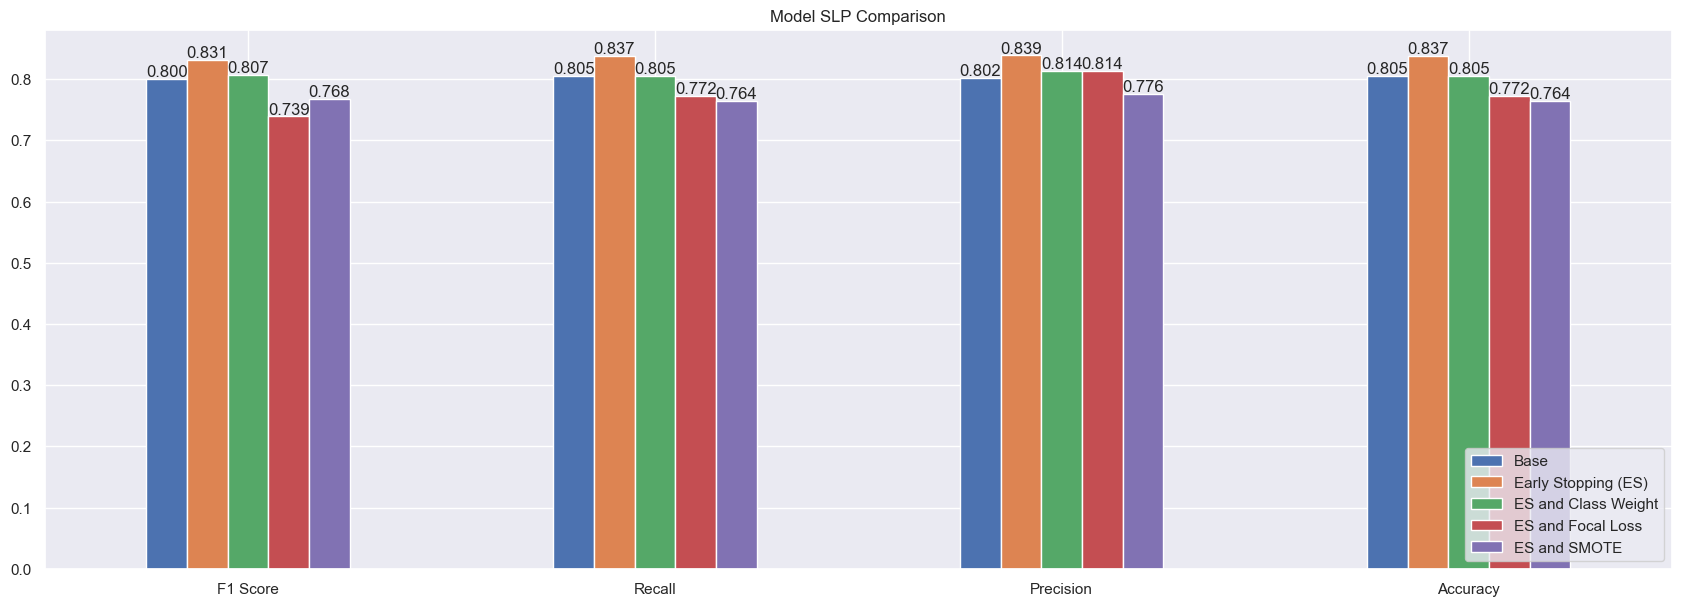

In [45]:
model_results = pd.DataFrame({
    'F1 Score': [f1_slp, f1_slp_es, f1_slp_es_cw, f1_slp_es_focal, f1_slp_es_smote],
    'Recall': [rec_slp, rec_slp_es, rec_slp_es_cw, rec_slp_es_focal, rec_slp_es_smote],
    'Precision': [prec_slp, prec_slp_es, prec_slp_es_cw, prec_slp_es_focal, prec_slp_es_smote],
    'Accuracy': [acc_slp, acc_slp_es, acc_slp_es_cw, acc_slp_es_focal, acc_slp_es_smote]
}, index=['Base', 'Early Stopping (ES)', 'ES and Class Weight', 'ES and Focal Loss', 'ES and SMOTE'])

model_results.T.plot(kind='bar', figsize=(21, 7))
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.title('Model SLP Comparison')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()


## Model Multi-Layer Perceptron (1 Hidden Layer)

In [46]:
nn_mlp = keras.models.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score])
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history_mlp = nn_mlp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[earlyStopping], class_weight=None)

Epoch 1/500


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - f1_score: 0.3994 - loss: 0.7065 - val_f1_score: 0.3059 - val_loss: 0.7026
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.4467 - loss: 0.6692 - val_f1_score: 0.3846 - val_loss: 0.6555
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score: 0.4865 - loss: 0.6383 - val_f1_score: 0.4872 - val_loss: 0.6149
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.5460 - loss: 0.6124 - val_f1_score: 0.5789 - val_loss: 0.5805
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score: 0.5949 - loss: 0.5908 - val_f1_score: 0.6400 - val_loss: 0.5518
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score: 0.6017 - loss: 0.5726 - val_f1_score: 0.6575 - val_loss: 0.5276
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.5890 - loss: 0.5574 - val_f1_score: 0.6849 - val_loss: 0.5070
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score: 0.5847 - loss: 0.5450 - val_f1_score: 0.7027 - val_l

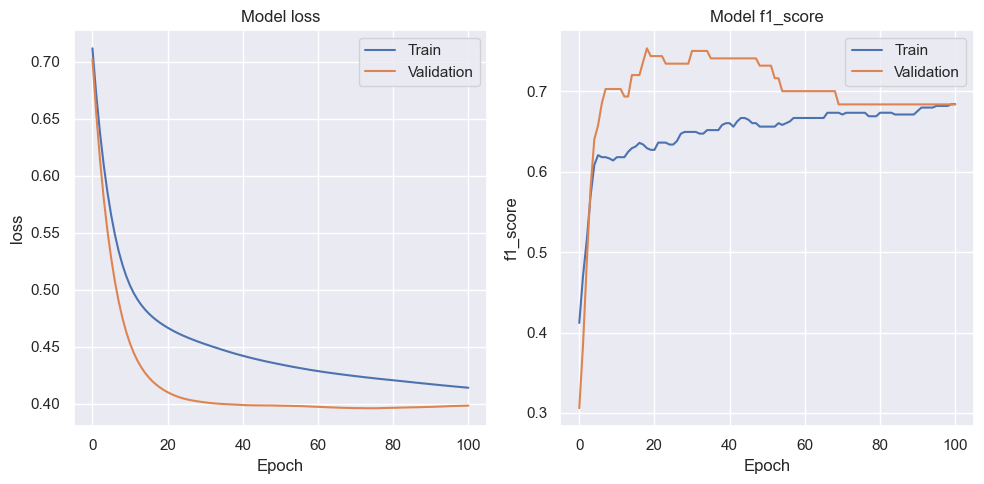

In [47]:
show_epoch(history_mlp.history, metric)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


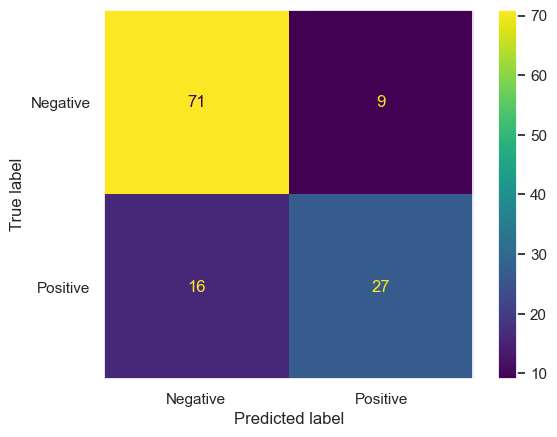

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.75      0.63      0.68        43

    accuracy                           0.80       123
   macro avg       0.78      0.76      0.77       123
weighted avg       0.79      0.80      0.79       123

F1 Score: 79.20%
Recall: 79.67%
Precision: 79.30%
Accuracy: 79.67%


In [48]:
f1_mlp, rec_mlp, prec_mlp, acc_mlp = show_result(X_val, y_val, nn_mlp)

## Model SVM

In [49]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

SVC()

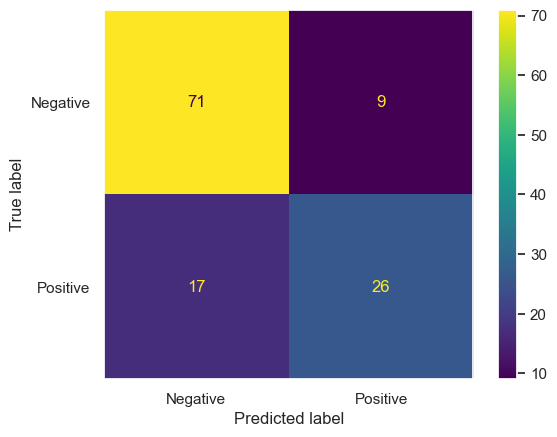

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        80
           1       0.74      0.60      0.67        43

    accuracy                           0.79       123
   macro avg       0.77      0.75      0.76       123
weighted avg       0.78      0.79      0.78       123

F1 Score: 78.28%
Recall: 78.86%
Precision: 78.45%
Accuracy: 78.86%


In [50]:
f1_svm, rec_svm, prec_svm, acc_svm = show_result(X_val, y_val, svm)

# Final Model

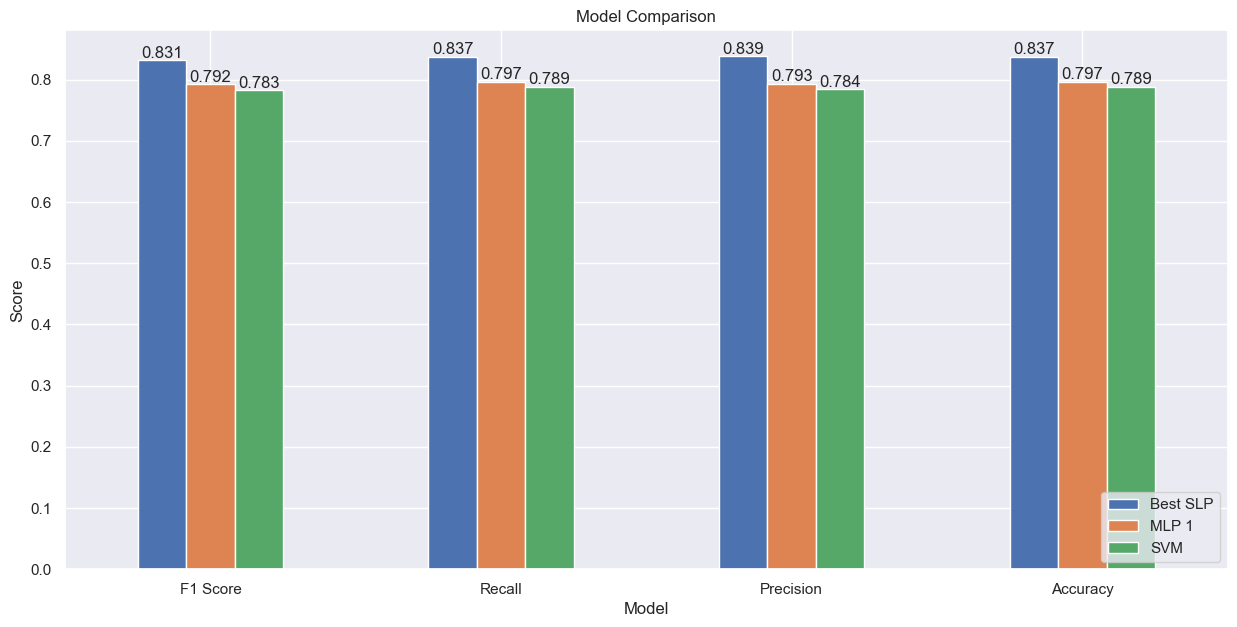

In [51]:
metrics = {
    'F1 Score': [f1_slp_es, f1_mlp, f1_svm],
    'Recall': [rec_slp_es, rec_mlp, rec_svm],
    'Precision': [prec_slp_es, prec_mlp, prec_svm],
    'Accuracy': [acc_slp_es, acc_mlp, acc_svm]
}
df_metrics = pd.DataFrame(metrics, index=['Best SLP', 'MLP 1', 'SVM']).T
df_metrics.plot(kind='bar', figsize=(15, 7)) 
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xlabel('Model')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [58]:
best_model = keras.models.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score])
earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
history_best_model = best_model.fit(X_train_val, y_train_val, epochs=500, callbacks=[earlyStopping])

Epoch 1/500


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.4183 - loss: 0.7953
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4469 - loss: 0.7732
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.4557 - loss: 0.7534
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.4821 - loss: 0.7354
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.4968 - loss: 0.7190
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5122 - loss: 0.7041
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5406 - loss: 0.6905
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5520 - loss: 0.6781
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.5599 - loss: 0.6667 
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.5717 - loss: 0.6564 
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5728 - loss: 0.6468
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5794 - 

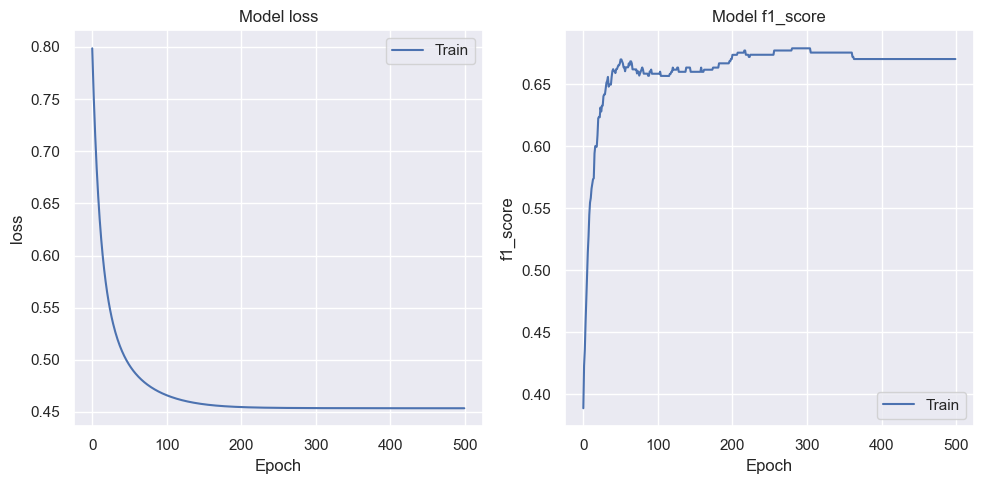

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


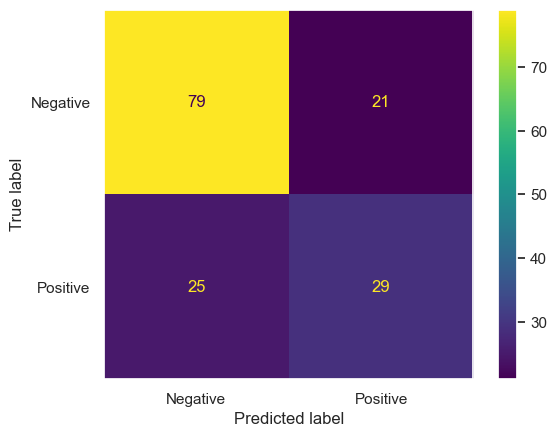

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       100
           1       0.58      0.54      0.56        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.67       154
weighted avg       0.70      0.70      0.70       154

F1 Score: 69.85%
Recall: 70.13%
Precision: 69.66%
Accuracy: 70.13%


In [59]:
show_epoch(history_best_model.history, metric, with_val=False)
f1_final, rec_final, prec_final, acc_final = show_result(X_test, y_test, best_model)

In [60]:
final_metric = {
    'F1 Score': f"{f1_final*100:.2f}",
    'Recall': f"{rec_final*100:.2f}",
    'Precision': f"{prec_final*100:.2f}",
    'Accuracy': f"{acc_final*100:.2f}"
}
df_final_metric = pd.DataFrame(final_metric, index=['Best Model']).T
display(df_final_metric)

,Best Model
F1 Score,69.85
Recall,70.13
Precision,69.66
Accuracy,70.13
